In [ ]:
import os
os.environ['KAGGLE_USERNAME']="satyakalyansai"
os.environ['KAGGLE_KEY']="218ea702fed5a32a5f7fa99ca7da9dd9"

In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [ ]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("/content/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)
print(type(content))

<class 'dict'>


In [ ]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 1955246


In [ ]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

Number of unique words = 18079


In [ ]:

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]
print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 18079


In [ ]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("/content/flickr30k_train.txt", 'r') as file:
    train_file_data = file.read()

with open ("/content/flickr30k_test.txt", 'r') as file:
    test_file_data = file.read()

In [ ]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]
train_data[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [ ]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)
train_content['1001896054']

['startseq a man with reflective safety clothes and ear protection drives a john deere tractor on a road  endseq',
 'startseq john deere tractors cruises down a street while the driver wears easy to see clothing  endseq',
 'startseq a man in a neon green and orange uniform is driving on a green tractor  endseq',
 'startseq a man in a tractor wearing headphones driving down a paved street  endseq',
 'startseq a man driving a john deere tractor on a main road in the country  endseq']

In [ ]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))
for layer in model.layers:
  layer.trainable=True

102981632/102967424 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [ ]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tensor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


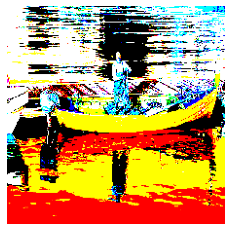

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img = preprocess_image("/content/flickr30k_images/flickr30k_images/4376178.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [ ]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
from time import time

train_encoding = {}
# Create a dictionary of imageID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "/content/flickr30k_images/flickr30k_images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Encoding in progress... STEP 1000
Encoding in progress... STEP 1100
Encoding in progress... STEP 1200
Encoding in progress... STEP 1300
Encoding in progress... STEP 1400
Encoding in progress... STEP 1500
Encoding in progress... STEP 1600
Encoding in progress... STEP 1700
Encoding in progress... STEP 1800
Encoding in progress... STEP 1900
Encoding in progress... STEP 2000
Encoding in progress... STEP 2100
Encoding in progress... STEP 2200
Encoding in progress... STEP 2300
Encoding in progress... STEP 2400
Encoding in progress... STEP 2500
Encoding in progress... STEP 2600
Encoding in progress... STEP 2700
Encoding in progress... STEP 2800
Encoding in progress... ST

In [ ]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [ ]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "/content/flickr30k_images/flickr30k_images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Total time taken: 86.87870264053345 s


In [ ]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

In [ ]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [ ]:
print(len(index_to_word))

18079


In [ ]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [ ]:
# Add startseq and endseq also to the mappings
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [ ]:
print(VOCAB_SIZE)

18082


In [ ]:
import pickle
with open("/content/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [ ]:
with open("/content/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [ ]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [ ]:
print(max_len)

80


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("glove.6B.300d.txt",encoding='utf8')

--2022-05-05 04:14:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-05 04:14:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-05 04:14:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Create a mapping from word to embedding
embeddings_index = {} # empty dictionary

for line in file:
    values = line.split()

    word = values[0]
    coefs = np.array (values[1:], dtype='float')
    embeddings_index[word] = coefs

file.close()

In [ ]:
embeddings_index["apple"]

array([-0.20842  , -0.019668 ,  0.063981 , -0.71403  , -0.21181  ,
       -0.59283  , -0.15316  ,  0.044217 ,  0.63289  , -0.84821  ,
       -0.21129  , -0.19763  ,  0.19029  , -0.56226  ,  0.27126  ,
        0.23782  , -0.5189   , -0.24518  ,  0.035243 ,  0.096833 ,
        0.24898  ,  0.71279  ,  0.038279 , -0.10514  , -0.4779   ,
       -0.39515  , -0.27194  , -0.44428  ,  0.06113  , -0.2318   ,
       -0.35901  , -0.18239  ,  0.035507 , -0.087719 , -1.0816   ,
       -0.42521  ,  0.003224 , -0.45991  , -0.043462 , -0.39031  ,
        0.519    ,  0.21139  , -0.25527  ,  1.1805   , -0.19041  ,
       -0.12156  ,  0.034186 , -0.062316 ,  0.14421  , -0.53366  ,
        0.47425  , -0.4471   ,  0.58047  ,  0.43578  ,  0.1321   ,
       -0.095712 , -0.37182  , -0.013837 ,  0.20601  , -0.10099  ,
        0.10685  , -0.33723  ,  0.10986  ,  0.34796  , -0.099839 ,
        0.36942  , -0.52917  ,  0.12407  , -0.46127  , -0.38483  ,
       -0.10114  , -0.17634  ,  0.37574  ,  0.16377  , -0.2198

In [ ]:
embedding_dim = 300

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(18082, 300)

In [ ]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=300, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

In [ ]:
from keras.layers.merge import add

# Decode the inputs

# So, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 300)      5424600     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

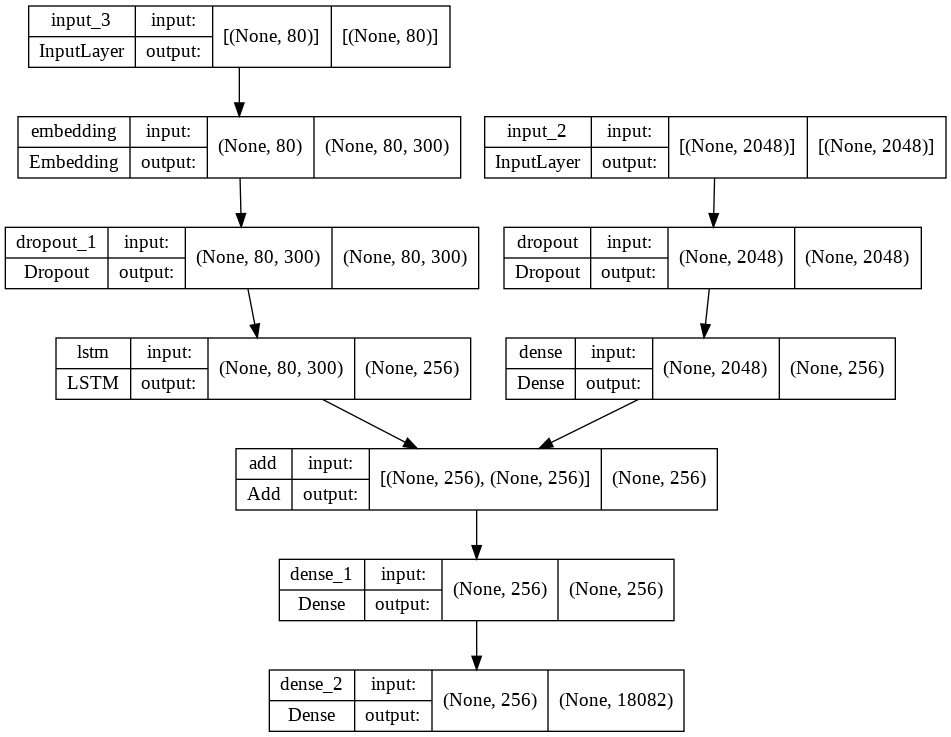

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0

In [ ]:
epochs = 50
batch_size = 32
steps = len(train_content)//batch_size

In [ ]:
  for i in range(epochs):
      # Create an instance of the generator
      generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
      model.fit_generator(generator, steps_per_epoch=steps)
      model.save('modelresnet50_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


 16/906 [..............................] - ETA: 6:48 - loss: 2.4628